In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/CV/exte2/RESEARCHCOMPUTERVISION/invision_small"

/content/drive/My Drive/CV/exte2/RESEARCHCOMPUTERVISION/invision_small


In [3]:
import os
import cv2
import json
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def extract_frame(video_path, frame_number, output_path):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        cv2.imwrite(output_path, frame)
    cap.release()
    return ret

def read_ground_truth(gt_file):
    with open(gt_file, 'r') as f:
        data = json.load(f)

    gt_data = {}
    for frame in data:
        frame_id = frame['frameId']
        if 'network_detections' in frame and frame['network_detections']:
            gt_data[frame_id] = frame['network_detections']

    return gt_data

import os
import cv2
import json
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom

def create_xml_annotation(filename, size, objects):
    root = ET.Element("annotation")
    ET.SubElement(root, "filename").text = filename

    source = ET.SubElement(root, "source")
    ET.SubElement(source, "database").text = "cloe invision data"
    ET.SubElement(source, "annotation").text = "cloe invision data"
    ET.SubElement(source, "image").text = "flickr"

    size_elem = ET.SubElement(root, "size")
    ET.SubElement(size_elem, "width").text = str(size[0])
    ET.SubElement(size_elem, "height").text = str(size[1])
    ET.SubElement(size_elem, "depth").text = "3"

    ET.SubElement(root, "segmented").text = "0"

    valid_objects = []
    for obj in objects:
        if obj['class'].lower() == 'person' and all(coord >= 0 for coord in obj['bbox']):
            object_elem = ET.SubElement(root, "object")
            ET.SubElement(object_elem, "name").text = "person"
            ET.SubElement(object_elem, "pose").text = "Unspecified"
            ET.SubElement(object_elem, "truncated").text = "0"
            ET.SubElement(object_elem, "difficult").text = "0"

            bndbox = ET.SubElement(object_elem, "bndbox")
            ET.SubElement(bndbox, "xmin").text = str(int(obj['bbox'][0]))
            ET.SubElement(bndbox, "ymin").text = str(int(obj['bbox'][1]))
            ET.SubElement(bndbox, "xmax").text = str(int(obj['bbox'][2]))
            ET.SubElement(bndbox, "ymax").text = str(int(obj['bbox'][3]))

            ET.SubElement(object_elem, "confidence").text = str(obj['ml_score'])
            valid_objects.append(obj)

    if not valid_objects:
        return None

    xml_str = ET.tostring(root, encoding='unicode')
    dom = minidom.parseString(xml_str)
    return dom.toprettyxml(indent="    ")

def process_camera(video_file, gt_file, output_folder):
    frames_folder = os.path.join(output_folder, "JPEGImages")
    annotations_folder = os.path.join(output_folder, "Annotations")
    os.makedirs(frames_folder, exist_ok=True)
    os.makedirs(annotations_folder, exist_ok=True)

    gt_data = read_ground_truth(gt_file)

    for frame_num in sorted(gt_data.keys()):
        frame_filename = f"{os.path.splitext(os.path.basename(video_file))[0]}_{frame_num:08d}.jpg"
        frame_path = os.path.join(frames_folder, frame_filename)

        # Extract frame
        if extract_frame(video_file, frame_num, frame_path):
            # Get frame size
            img = cv2.imread(frame_path)
            height, width = img.shape[:2]

            objects = gt_data[frame_num]
            xml_content = create_xml_annotation(frame_filename, (width, height), objects)

            if xml_content is not None:
                xml_filename = f"{os.path.splitext(frame_filename)[0]}.xml"
                with open(os.path.join(annotations_folder, xml_filename), 'w') as f:
                    f.write(xml_content)
                print(f"Processed frame {frame_num} for {os.path.basename(video_file)}")
            else:
                # Remove the frame if no valid objects were found
                os.remove(frame_path)
                print(f"Skipped frame {frame_num} for {os.path.basename(video_file)} - No valid objects")
        else:
            print(f"Failed to extract frame {frame_num} from {os.path.basename(video_file)}")


def main():
    input_folder = "/content/drive/My Drive/CV/exte2/RESEARCHCOMPUTERVISION/invision_small"
    base_output_folder = "/content/drive/My Drive/CV/exte2/RESEARCHCOMPUTERVISION/invision_small/cloe"

    dataset_splits = {
        "train_dataset": ["1_1", "1_3", "1_4", "2_2", "2_3", "2_4"],
        "validation_dataset": ["2_1"],
        "test_dataset": ["1_2"]
    }

    cameras = [
        ("1_1", "example_footage/cam_1_1_undistorted.mp4", "json_output/cam_1_1.json"),
        ("1_2", "example_footage/cam_1_2_undistorted.mp4", "json_output/cam_1_2.json"),
        ("1_3", "example_footage/cam_1_3_undistorted.mp4", "json_output/cam_1_3.json"),
        ("1_4", "example_footage/cam_1_4_undistorted.mp4", "json_output/cam_1_4.json"),
        ("2_1", "example_footage/cam_2_1_undistorted.mp4", "json_output/cam_2_1.json"),
        ("2_2", "example_footage/cam_2_2_undistorted.mp4", "json_output/cam_2_2.json"),
        ("2_3", "example_footage/cam_2_3_undistorted.mp4", "json_output/cam_2_3.json"),
        ("2_4", "example_footage/cam_2_4_undistorted.mp4", "json_output/cam_2_4.json"),
    ]

    for split, camera_ids in dataset_splits.items():
        split_output_folder = os.path.join(base_output_folder, split)
        os.makedirs(split_output_folder, exist_ok=True)

        for camera_id, video_file, gt_file in cameras:
            if camera_id in camera_ids:
                print(f"Processing camera {camera_id} for {split}...")
                video_path = os.path.join(input_folder, video_file)
                gt_path = os.path.join(input_folder, gt_file)
                camera_output_folder = split_output_folder
                #camera_output_folder = os.path.join(split_output_folder, f"camera_{camera_id}")#
                os.makedirs(camera_output_folder, exist_ok=True)
                process_camera(video_path, gt_path, camera_output_folder)
                print(f"Finished processing camera {camera_id} for {split}")

    print("Processing complete. Now shuffling datasets...")

if __name__ == "__main__":
    main()


Processing camera 1_1 for train_dataset...
Processed frame 0 for cam_1_1_undistorted.mp4
Processed frame 1 for cam_1_1_undistorted.mp4
Processed frame 2 for cam_1_1_undistorted.mp4
Processed frame 3 for cam_1_1_undistorted.mp4
Processed frame 4 for cam_1_1_undistorted.mp4
Processed frame 5 for cam_1_1_undistorted.mp4
Processed frame 6 for cam_1_1_undistorted.mp4
Processed frame 7 for cam_1_1_undistorted.mp4
Processed frame 8 for cam_1_1_undistorted.mp4
Processed frame 9 for cam_1_1_undistorted.mp4


KeyboardInterrupt: 

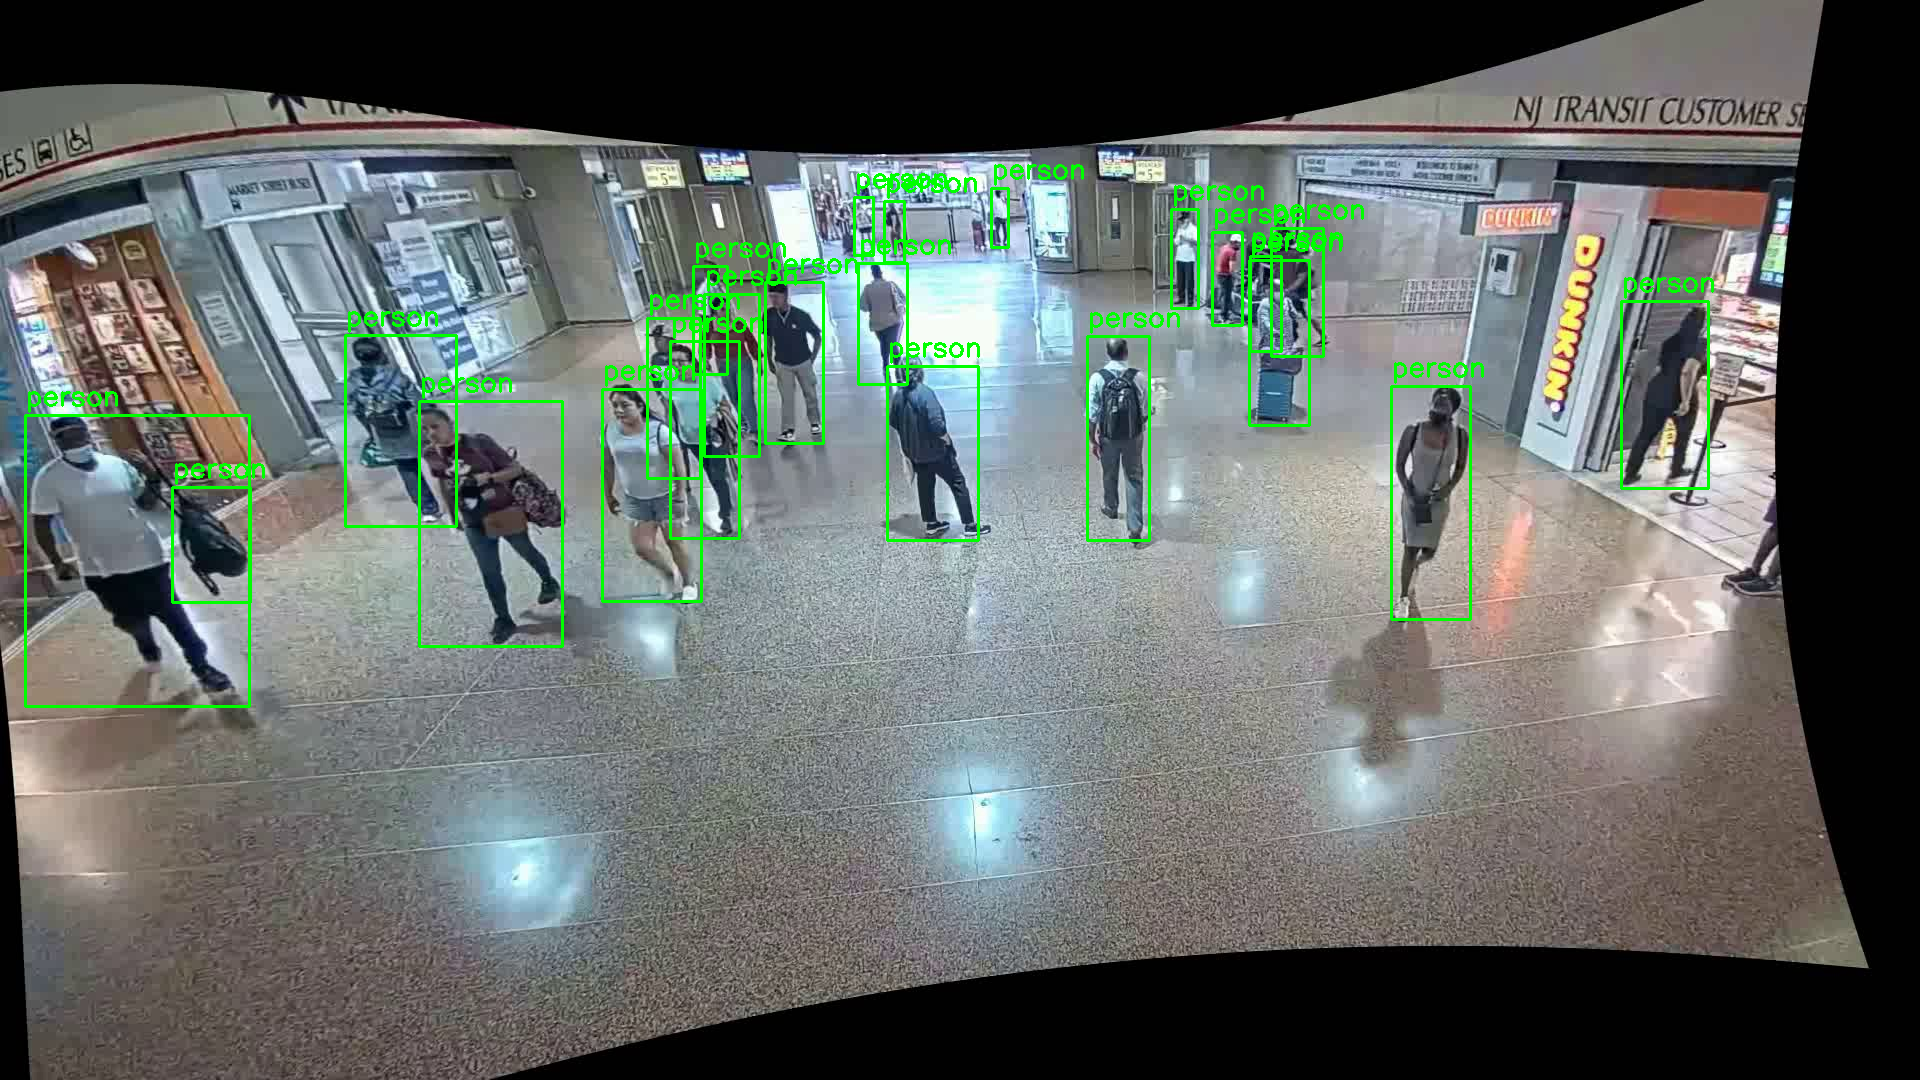

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
from google.colab.patches import cv2_imshow

def draw_annotations(image_path, xml_path):
    img = cv2.imread(image_path)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)


        cv2.putText(img, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2_imshow(img)

def main():
    image_path = '/content/drive/My Drive/CV/exte2/RESEARCHCOMPUTERVISION/invision_small/data/camera_1_1/JPEGImages/cam_1_1_undistorted_00000000.jpg'
    xml_path = '/content/drive/My Drive/CV/exte2/RESEARCHCOMPUTERVISION/invision_small/data/camera_1_1/Annotations/cam_1_1_undistorted_00000000.xml'

    if not os.path.exists(image_path):
        print(f"Error: Image file not found: {image_path}")
        return

    if not os.path.exists(xml_path):
        print(f"Error: XML file not found: {xml_path}")
        return

    draw_annotations(image_path, xml_path)

if __name__ == "__main__":
    main()